# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [83]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
# Load the data
DATA_PATH = './asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [85]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Importar Images

In [86]:
# The following code removes the label column from the data and converts the data into numpy arrays
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [87]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Create a function that will allow you to split the previously loaded validation set
    into valition and test.
    '''
    if shuffle:
        idx = np.arange(len(x))     # create an array of indices
        np.random.shuffle(idx)      # shuffle the indices
        x = x[idx]                  # shuffle the array of images
        y = y[idx]                  # shuffle the array of labels
    # split the images and labels into training and validation sets
    return x[:int(len(x)*pct)], y[:int(len(y)*pct)], x[int(len(x)*pct):], y[int(len(y)*pct):]
   

In [88]:
# Split validation set into validation and test
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [89]:
# check shapes
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(27455, 784) (27455,)
(3586, 784) (3586,)
(3586, 784) (3586,)


In [90]:
### The following code is to check the number of unique labels in the dataset

alphabet=list(string.ascii_lowercase)  # create a list of all the alphabets
alphabet.remove('j')                   # remove the letter j from the list
alphabet.remove('z')                   # remove the letter z from the list
print(len(alphabet))

24


### Normalise

In [91]:
# Data normalization
def normalise(x_mean, x_std, x_data):
    '''
    This function allow you to normalize the data
    '''
    return (x_data - x_mean) / x_std

In [92]:
x_mean = np.mean(x_train)   # calculate the mean of the training set
x_std = np.std(x_train)     # calculate the standard deviation of the training set

x_train = normalise(x_mean, x_std, x_train)     # normalize the training set
x_val = normalise(x_mean, x_std, x_val)         # normalize the validation set
x_test = normalise(x_mean, x_std, x_test)       # normalize the test set

In [93]:
x_train.mean(), x_train.std()

(3.6268384e-06, 0.99999946)

### Graficar muestras

In [94]:
def plot_alphabet(image):
    '''
    This function allow you to plot the image of the alphabet
    '''
    plt.imshow(image.reshape(28,28), cmap='gray')   # reshape the image to 28x28 and plot it
    plt.axis('off')
    plt.show()

This image belongs to the letter o


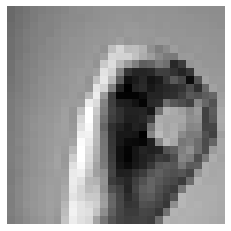

In [95]:
rnd_idx = np.random.randint(len(y_test))   # create a random index

print(f'This image belongs to the letter {alphabet[y_test[rnd_idx]]}')
plot_alphabet(x_test[rnd_idx])

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

#### Mini batches

In [96]:
# mini-batch generator
def minibatch(mb_size, x, y, shuffle=True):
    '''
    This function allow you to create the mini-batches
    '''
    assert x.shape[0] == y.shape[0], 'Sample Qty. Error'    # check if the number of images and labels are equal
    total_data = x.shape[0]                                 # get the total number of data

    if shuffle:
        idxs = np.arange(total_data)                        # create an array of indices
        np.random.shuffle(idxs)                             # shuffle the indices
        x = x[idxs]                                         # shuffle the array of images
        y = y[idxs]                                         # shuffle the array of labels
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))   # return the mini-batch

## Nuestra clase Linear, ReLU y Sequential

In [97]:
# This class creates a tensor from a numpy array
class np_tensor(np.ndarray): pass  

### Clase Linear

In [98]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        This function initializes the parameters using Kaiming He initialization
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)  # initialize the weights
        self.b = (np.zeros((output_size, 1))).view(np_tensor)                                        # initialize the biases
    def __call__(self, X):
        '''
        This function performs the forward pass
        '''
        Z = self.W @ X + self.b         # calculate the linear transformation
        return Z
    def backward(self, X, Z):
        '''
        This function performs the backward pass
        '''
        X.grad = self.W.T @ Z.grad                              # calculate the gradients of the inputs    
        self.W.grad = Z.grad @ X.T                              # calculate the gradients of the weights
        self.b.grad = np.sum(Z.grad, axis=1, keepdims=True)     # sum the gradients of the biases

### Clase ReLU

In [99]:
class ReLU():
    def __call__(self, Z):
        return np.maximum(0, Z)     # Forward pass of the ReLU activation function
    def backward(self, Z, A):
        Z.grad = A.grad.copy()      # Backward pass of the ReLU activation function
        Z.grad[Z <= 0] = 0          # Set the gradients to zero where the inputs are negative

### Clase Sequential

In [101]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        This function initializes the layers
        '''
        self.layers = layers    # initialize the layers
        self.x = None           # initialize the input
        self.outputs = {}       # initialize the outputs
    def __call__(self, X):
        self.x = X                                      # set the input
        self.outputs['l0'] = self.x                     # set input of the first layer
        for i, layer in enumerate(self.layers, 1):      # loop through the layers
            self.x = layer(self.x)                      # calculate the output of the layer
            self.outputs['l'+str(i)] = self.x           # set the output of the layer
        return self.x
    def backward(self):
        for i in reversed(range(len(self.layers))):                                         # loop through the layers in reverse order
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])   # backward pass for each layer
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue                # skip the ReLU layer
            layer.W = layer.W - learning_rate * layer.W.grad    # update the weights
            layer.b = layer.b - learning_rate * layer.b.grad    # update the biases
    def predict(self, X):
        return np.argmax(self.__call__(X))                      # predict the class of the input   

### Cost Function

In [108]:
def softmaxXEntropy(x, y):
    '''
    This function calculates the softmax cross entropy loss
    '''
    batch_size = x.shape[1]         # get the batch size
    exp_scores = np.exp(x)          # calculate the exponential of the scores
    probs = exp_scores / exp_scores.sum(axis=0)   # calculate the probabilities
    preds = probs.copy()                          # make a copy of the probabilities

    y_hat = probs[y.squeeze(), np.arange(batch_size)]  # get the probabilities of the correct class
    cost = np.sum(-np.log(y_hat)) / batch_size          # calculate the loss for the batch

    probs[y.squeeze(), np.arange(batch_size)] -= 1     # subtract 1 from the probabilities of the correct class
    x.grad = probs.copy()                               # define the gradients of the inputs

    return preds, cost

### Loop de entrenamiento

In [103]:
def train(model, epochs, mb_size = 128, learning_rate= 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(minibatch(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))                 # calculate the scores
            _, cost = softmaxXEntropy(scores, y)
            model.backward()                                     # calculate the gradients
            model.update(learning_rate)                          # update the parameters
        print(f'Cost: {cost}, Accuracy: {accuracy(x_val, y_val, mb_size)}')   # print the cost and accuracy

In [104]:
def accuracy(x, y, mb_size):
    correct = 0           
    total = 0
    for i, (x,y) in enumerate(minibatch(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))                           # predict the class of the input
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())   # calculate the number of correct predictions
        total += pred.shape[1]                                      # calculate the total number of predictions
        return correct / total                                      # calculate the accuracy

### Create your model and train it

In [170]:
model = Sequential_layers([Linear(784, 300), ReLU(), Linear(300, 300), ReLU(), Linear(300, 300), ReLU(), Linear(300, 24)])    
mb_size = 512
learning_rate = 1e-4
epochs = 20

In [171]:
train(model, epochs, mb_size, learning_rate)

Cost: 0.8229545526254431, Accuracy: 0.546875
Cost: 0.38410342639263334, Accuracy: 0.671875
Cost: 0.2181771594334191, Accuracy: 0.751953125
Cost: 0.11246239849009539, Accuracy: 0.751953125
Cost: 0.07315513490572247, Accuracy: 0.736328125
Cost: 0.04656891151571437, Accuracy: 0.74609375
Cost: 0.03142512236661389, Accuracy: 0.71875
Cost: 0.030157919942043004, Accuracy: 0.7734375
Cost: 0.02212581258899344, Accuracy: 0.78125
Cost: 0.018944253430004394, Accuracy: 0.76171875
Cost: 0.015253038801500291, Accuracy: 0.7578125
Cost: 0.013792930511590388, Accuracy: 0.7421875
Cost: 0.012207643126475282, Accuracy: 0.78125
Cost: 0.01089269055722728, Accuracy: 0.767578125
Cost: 0.00850107342387957, Accuracy: 0.7734375
Cost: 0.009421749203725809, Accuracy: 0.7578125
Cost: 0.006821654914078076, Accuracy: 0.736328125
Cost: 0.009388138804182903, Accuracy: 0.765625
Cost: 0.008524160019156917, Accuracy: 0.783203125
Cost: 0.0066529962283326865, Accuracy: 0.755859375


In [172]:
print(accuracy(x_test, y_test, mb_size))

0.744140625


### Test your model on Random data from your test set

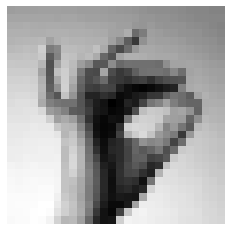

el valor predicho es: f el valor real es:f


In [192]:
idx = np.random.randint(len(y_test))
plot_alphabet(x_test[idx].reshape(28,28))
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {alphabet[pred]} el valor real es:{alphabet[y_test[idx]]}')